
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [45]:
# Bibliotecas básicas
import pandas as pd
import numpy as np

# Bibliotecas relacionadas ao treinamento do modelo
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import DistilBertTokenizer, DistilBertModel
from gensim.models import KeyedVectors

# Bibliotecas relacionadas a exibição de gráficos
import matplotlib.pyplot as plt

In [2]:
# Carregando modelo de transformer pré-treinado e tokenizer (DistilBERT)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [4]:
# Carregando modelo pré-treinado de vetores de palavras (utilizado no feature-based encoding)
word_vectors = KeyedVectors.load_word2vec_format('../embeddings/wiki.pt.vec', binary=False)

In [5]:
# Carregando dataset
df = pd.read_csv('../datasets/buscape_preprocessed_balanced.csv')

In [6]:
# Montando um batch de apenas 1000 instâncias
batch_1 = df[:1000]

In [65]:
# Verificando quantidades de rating
batch_1['rating'].value_counts()

rating
1    906
0     94
Name: count, dtype: int64

In [7]:
# Limpando lista de sentenças e definindo labels
texts = batch_1['review_text'].tolist()
labels = batch_1['rating'].tolist()

In [8]:
def clear_sentences(sentences):
    new_list_texts = []
    for item in sentences:
        item_fixed = item[1:-1]  
        new_list_texts.append(item_fixed)
    
    return [s[1:-1] for s in new_list_texts]

In [9]:
texts = clear_sentences(texts)

In [10]:
print(len(texts))
print(len(labels))

1000
1000


In [11]:
# Dividindo dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [12]:
# Conferindo quantidades
print(f'textos para treino: {len(train_texts)}')
print(f'textos para teste: {len(test_texts)}')
print(f'labels para treino: {len(train_labels)}')
print(f'labels para teste: {len(test_labels)}')

textos para treino: 800
textos para teste: 200
labels para treino: 800
labels para teste: 200


In [13]:
# Função que gera incorporações baseadas em recursos usando vetores de palavras pré-treinados
def generate_feature_based_embedding(text):
    words = text.split()
    embeddings = [word_vectors[word] for word in words if word in word_vectors]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(300)

In [14]:
# Gerando feature-based embeddings para treino
train_feature_based_embeddings = np.array([generate_feature_based_embedding(text) for text in train_texts])

In [15]:
# Gerando feature-based embeddings para teste
test_feature_based_embeddings = np.array([generate_feature_based_embedding(text) for text in test_texts])

In [16]:
# Tokenizando
train_inputs = tokenizer(train_texts, padding=True, truncation=True, max_length=50, return_tensors="pt")

In [17]:
# CLS: 101
# SEP: 102
train_inputs.input_ids[0:3]

tensor([[  101,  8118,  2368,  3653,  9153, 14262,  7903,  2891,  2139,  7367,
         27390,  2319,  3540, 21722, 29461,  5740, 23689,  6590,  2099,  1041,
          2041,  8180,  4569, 16288,  2015, 11498,  8529,  2050,  2918, 23689,
          6590,  2099,  2139,  7367, 27390,  2319,  3540, 26927,  3567,  2850,
         29031,  2361, 16371,  2213,  6643,  2483,  7861,  4078,  2368,   102],
        [  101, 10882,  4226,  2072,  2938,  2483, 21156, 14643, 16339, 27885,
          3089,  3654,  3527,  1051, 10861,  2175, 13473,  2072, 14163,  9956,
          8945,  2213,  3690, 10861,  7327,  8391, 15781,  9686,  4842, 12462,
          1051, 10861,  6583,  2080,  2175, 13473,  2072, 11265, 25311, 12248,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101, 14163,  9956, 21183,  4014,  1051, 10861,  2175, 13473,  2072,
         24898,  1051, 10861,  6583,  2080,  2175, 13473,  2072, 21877,  3736,
          3527,   102,     0,     0,     0,     0,

In [18]:
# Gerando transformer-based embeddings
with torch.no_grad():
    train_outputs = model(**train_inputs).last_hidden_state
transformer_embeddings = train_outputs.numpy()

In [19]:
# Foi gerado uma matriz de 3 dimensão, optei pelo reshape desta matriz de transformers embeddings
transformer_embeddings.shape

(800, 50, 768)

In [20]:
# Reshape da matriz 
reshaped_transformer_embeddings = transformer_embeddings.reshape(transformer_embeddings.shape[0], -1)

In [21]:
reshaped_transformer_embeddings.shape

(800, 38400)

In [22]:
# Concatenando train_feature_based_embeddings e reshaped_transformer_embeddings
combined_embeddings = np.concatenate((train_feature_based_embeddings, reshaped_transformer_embeddings), axis=1)

In [23]:
combined_embeddings.shape

(800, 38700)

In [25]:
# Definindo treino utilizando MLP com PyTorch
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(p=0.05)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

In [26]:
input_dim = 300 + reshaped_transformer_embeddings.shape[1]  # Dimensões combinadas
hidden_dim1 = 128
hidden_dim2 = 64
mlp_model = MLP(input_dim, hidden_dim1, hidden_dim2)

In [27]:
# Convertendo dados para PyTorch tensors
train_embeddings = torch.tensor(combined_embeddings, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)

In [28]:
# Definindo função loss e optmizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=5e-4)

In [29]:
# Lista para armazenar métricas
losses = []
accuracies = []

# Treinando o modelo
num_epochs = 30
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = mlp_model(train_embeddings)
    loss = criterion(outputs, train_labels.view(-1, 1))
    loss.backward()
    optimizer.step()
    
    predicted_labels = (outputs >= 0.5).float()
    accuracy = (predicted_labels == train_labels).float().mean()
    
    losses.append(loss.item())
    accuracies.append(accuracy.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

Epoch [1/30], Loss: 0.6615, Accuracy: 0.9075
Epoch [2/30], Loss: 0.3691, Accuracy: 0.9075
Epoch [3/30], Loss: 0.3490, Accuracy: 0.9075
Epoch [4/30], Loss: 0.3059, Accuracy: 0.9075
Epoch [5/30], Loss: 0.3149, Accuracy: 0.9075
Epoch [6/30], Loss: 0.2832, Accuracy: 0.9075
Epoch [7/30], Loss: 0.2698, Accuracy: 0.9075
Epoch [8/30], Loss: 0.2792, Accuracy: 0.9075
Epoch [9/30], Loss: 0.2613, Accuracy: 0.9075
Epoch [10/30], Loss: 0.2476, Accuracy: 0.9075
Epoch [11/30], Loss: 0.2522, Accuracy: 0.9075
Epoch [12/30], Loss: 0.2307, Accuracy: 0.9075
Epoch [13/30], Loss: 0.2211, Accuracy: 0.9075
Epoch [14/30], Loss: 0.2176, Accuracy: 0.9075
Epoch [15/30], Loss: 0.2092, Accuracy: 0.9075
Epoch [16/30], Loss: 0.2022, Accuracy: 0.9055
Epoch [17/30], Loss: 0.1940, Accuracy: 0.9024
Epoch [18/30], Loss: 0.1887, Accuracy: 0.8963
Epoch [19/30], Loss: 0.1707, Accuracy: 0.8973
Epoch [20/30], Loss: 0.1692, Accuracy: 0.9055
Epoch [21/30], Loss: 0.1663, Accuracy: 0.9024
Epoch [22/30], Loss: 0.1513, Accuracy: 0.89

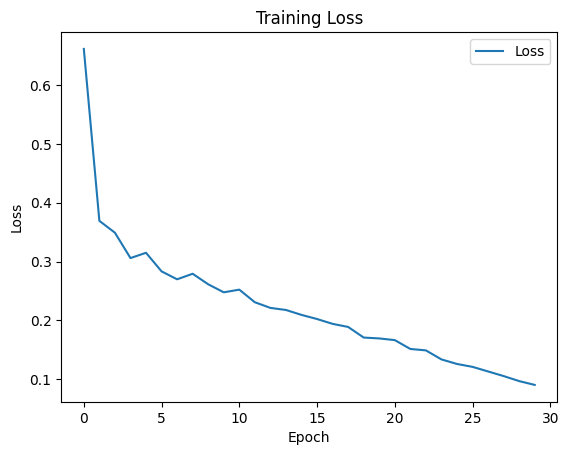

In [30]:
# Plotando gráfico de perda
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

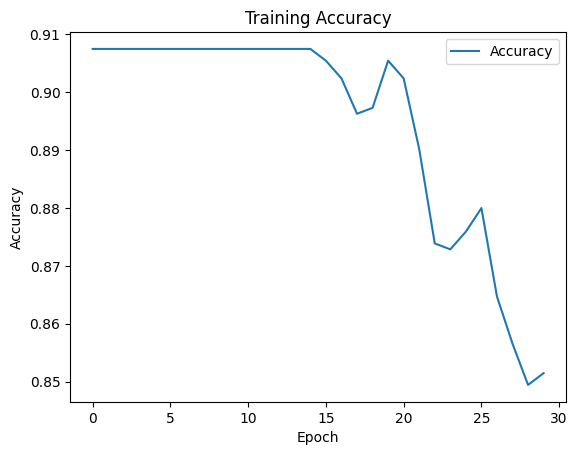

In [31]:
# Plotando gráfico de acurácia
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [32]:
# Avaliando o modelo com dados de teste
test_feature_based_embeddings = np.array([generate_feature_based_embedding(text) for text in test_texts])
test_inputs = tokenizer(test_texts, padding=True, truncation=True, max_length=50, return_tensors="pt")

In [33]:
with torch.no_grad():
    test_outputs = model(**test_inputs).last_hidden_state
test_transformer_embeddings = test_outputs.numpy()

In [34]:
test_transformer_embeddings.shape

(200, 50, 768)

In [35]:
reshape_test_transformer_embeddings = test_transformer_embeddings.reshape(test_transformer_embeddings.shape[0], -1)

In [36]:
reshape_test_transformer_embeddings.shape

(200, 38400)

In [37]:
test_combined_embeddings = np.concatenate((test_feature_based_embeddings, reshape_test_transformer_embeddings), axis=1)

In [38]:
test_embeddings = torch.tensor(test_combined_embeddings, dtype=torch.float32)

In [39]:
test_embeddings.shape

torch.Size([200, 38700])

In [40]:
with torch.no_grad():
    test_predictions = mlp_model(test_embeddings)

In [46]:
# Converte probabilidades para predições binárias
rounded_predictions = np.round(test_predictions.numpy()) 
accuracy = accuracy_score(test_labels, rounded_predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.89
